In [2]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt


edges_Enron = np.loadtxt('./data/Enron_DP.csv', delimiter=',')
# edges_DBLP = np.loadtxt('./data/DBLP_DP.csv', delimiter=',')
edges_Github = np.loadtxt('./data/Github_DP.csv', delimiter=',')

UEnron = np.loadtxt('./data/Enron_EBC.csv', delimiter=',')
UGithub = np.loadtxt('./data/Github_EBC.csv', delimiter=',')

In [3]:
v = ['a', 'b', 'v0', 'v1', 'v2', 'v3', 'v4', 'v5']
e = np.array([[0, 5], [0, 3], [1, 4], [0, 1], [0, 2], [0, 4], [1, 5], [1, 6], [1, 7], [2, 3], [6, 7]])

data_Train = (v, e)

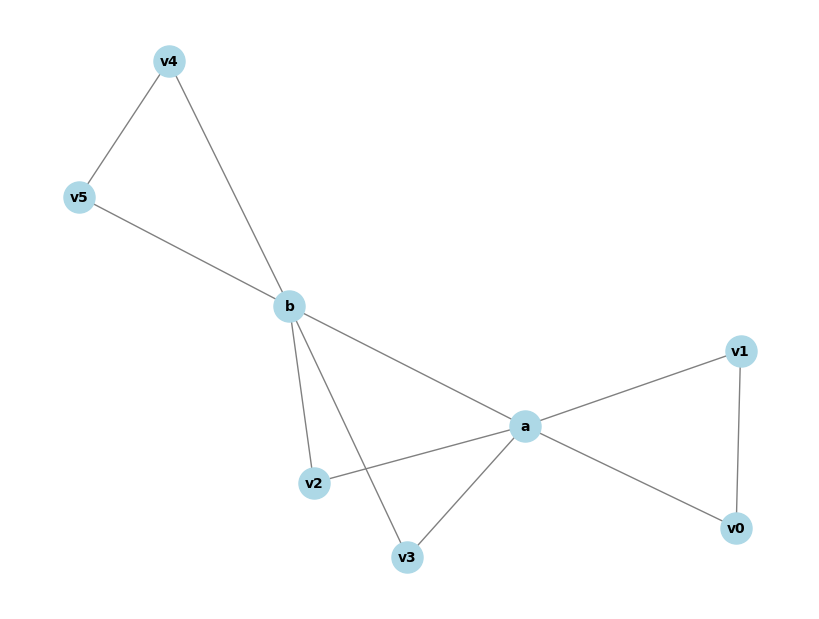

In [4]:
G = nx.Graph()

for i, node in enumerate(v):
    G.add_node(i, label=node)

for edge in e:
    G.add_edge(edge[0], edge[1])

pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_size=500, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
plt.show()


In [5]:
def get_nodes(G):
    nodes = set()
    
    for edge in G:
        nodes.add(int(edge[0]))
        nodes.add(int(edge[1]))
    
    sorted_nodes = sorted(nodes)
    return sorted_nodes

In [6]:
def degrees_nodes(G):
    deg = {}

    for edge in G:
        if edge[0] not in deg:
            deg[edge[0]] = 0
        if edge[1] not in deg:
            deg[edge[1]] = 0
            
        deg[edge[0]] += 1
        deg[edge[1]] += 1
    
    nodes = sorted(deg.keys())
    deg_array = np.array([deg[node] for node in nodes])
    
    return deg_array


In [7]:
def desordered_nodes(e):
    nodes_desordered = []
    for edge in e:
        if edge[0] not in nodes_desordered:
            nodes_desordered.append(edge[0])
        if edge[1] not in nodes_desordered:
            nodes_desordered.append(edge[1])

    return nodes_desordered

In [8]:
def EBC(lb, e, v):

    node_index = v.index(lb)

    if node_index > len(e):
        return 0

    neighbors = set()
    for edge in e:
        if edge[0] == node_index:
            neighbors.add(edge[1])
        elif edge[1] == node_index:
            neighbors.add(edge[0])

    if len(neighbors) == 0:
        return 0

    neighbors.add(node_index)

    subgraph_edges = []
    for edge in e:
        if edge[0] in neighbors and edge[1] in neighbors:
            subgraph_edges.append(edge)


    subgraph_nodes = desordered_nodes(subgraph_edges)

    new_index = subgraph_nodes.index(node_index)

    G = nx.Graph()
    G.add_edges_from(subgraph_edges)

    betweenness_centrality = nx.betweenness_centrality(G, normalized=False)
    
    return list(betweenness_centrality.values())[new_index]


In [9]:
def EBC_Geral(data):
    
    v, e = data
    ebcs = []

    for lb in v:
        ebc = EBC(lb, e, v)
        ebcs.append(ebc)

    return ebcs


In [10]:
EBC('a', e, v)

6.5

In [11]:
u = EBC_Geral((v, e))

u

[6.5, 6.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [12]:
def EBC_global_sensitivity(G):
    deg = degrees_nodes(G)
    dG = max(deg)
    dEBC = max(dG * (dG - 1)/4, dG)
    return dEBC    

In [13]:
EBC_global_sensitivity(e)

5.0

In [14]:
def EBC_local_sensitivity(G, v):

    id_nodes = get_nodes(G)
    edges = set(tuple(edge) for edge in G)

    LS = float('-inf')

    for lb in id_nodes:
        
        for i in range(len(id_nodes)):
            for j in range(i + 1, len(id_nodes)):

                edge = (id_nodes[i], id_nodes[j])
                
                if edge not in edges and (edge[1], edge[0]) not in edges: 
                    new_edges = edges.copy()
                    new_edges.add(edge)
                    new_edges = np.array(list(new_edges))

                    new_edges = new_edges[np.lexsort((new_edges[:, 1], new_edges[:, 0]))]

                    LSL = np.abs(EBC(v[lb], new_edges, v) - EBC(v[lb], np.array(list(edges))[np.lexsort((np.array(list(edges))[:, 1], np.array(list(edges))[:, 0]))], v))

                    if LSL > LS:
                        LS = LSL
        
        for edge in edges:
            new_edges = edges.copy()
            new_edges.remove(edge)
            new_edges.add(edge)
            new_edges = np.array(list(new_edges))

            new_edges = new_edges[np.lexsort((new_edges[:, 1], new_edges[:, 0]))]

            LSL = np.abs(EBC(v[lb], new_edges, v) - EBC(v[lb], np.array(list(edges))[np.lexsort((np.array(list(edges))[:, 1], np.array(list(edges))[:, 0]))], v))

            if LSL > LS:
                LS = LSL


    return LS

In [15]:
EBC_local_sensitivity(e, v)

3.0

In [16]:
def remove_duplicate_graphs(graph_list):
    unique_graphs = set()

    unique_graph_list = []

    for graph in graph_list:
        graph_tuple = tuple(map(tuple, graph))

        if graph_tuple not in unique_graphs:
            unique_graphs.add(graph_tuple)
            unique_graph_list.append(graph)

    return unique_graph_list

In [17]:
def neighborhood_time_t(G, t):

    possible_graphs = [G]
    inicio = 0
    fim = 1

    nodes = get_nodes(G)

    for k in range(t+1):
        aux = 0
        for graph in possible_graphs[inicio:fim]:

            edges = set(tuple(edge) for edge in graph)
            
            aux_nodes = nodes
            for i in nodes:
                for j in aux_nodes:
                    edge = (nodes[i], nodes[j])
                    if edge not in edges and (edge[1], edge[0]) not in edges and nodes[i] != nodes[j]: 
                        new_edges = edges.copy()
                        new_edges.add(edge)
                        new_edges = np.array(list(new_edges))

                        new_edges = np.sort(new_edges, 1)
                        new_edges = new_edges[np.lexsort((new_edges[:, 1], new_edges[:, 0]))]

                        possible_graphs.append(new_edges)

                        aux += 1
                        #print(f'{edge} é o {aux} nó adicionado')
                aux_nodes = aux_nodes[1:]


            for edge in edges:
                new_edges = edges.copy()
                new_edges.remove(edge)
                new_edges = np.array(list(new_edges))

                new_edges = np.sort(new_edges, 1)
                new_edges = new_edges[np.lexsort((new_edges[:, 1], new_edges[:, 0]))]
    
                possible_graphs.append(new_edges)

                aux += 1
                #print(f'{edge} é o {aux} nó removido')

        inicio = fim        
        fim = aux + inicio
    
    return possible_graphs



In [18]:
def EBC_local_sensitivity_time_t(G, t, r_id, deg = np.array([])):
    max_sent = float('-inf')

    GS = neighborhood_time_t(G, t)

    GS = remove_duplicate_graphs(GS)

    v = get_nodes(G)

    for edges in GS:
        act_seb = np.abs(EBC(v[r_id], edges, v) - EBC(v[r_id], G, v))
        if act_seb > max_sent:
            max_sent = act_seb


    return max_sent


In [19]:
def EBC_sensitivity_function(G, t, r_id, deg=[]):
    if len(deg) > 0:
        deg_r = deg[r_id]
    else:
        deg = degrees_nodes(G)
        deg_r = deg[r_id]

    delta_EBC = np.max([(deg_r + t) * (deg_r + t - 1)/4, deg_r + t])
    return delta_EBC

In [20]:
EBC_local_sensitivity_time_t(e, 0, 0)

3.0

In [21]:
EBC_sensitivity_function(e, 0, 0)

5.0

In [22]:
def Exponential_Mechanism(u, epsilon, G):
    
    dEBC = EBC_global_sensitivity(G)
    p = np.exp((epsilon * np.array(u)) / (2 * dEBC))
    p /= p.sum()

    return p

In [23]:
p = Exponential_Mechanism(u, 2, e)

p

array([0.27508873, 0.27508873, 0.07497042, 0.07497042, 0.07497042,
       0.07497042, 0.07497042, 0.07497042])

In [24]:
def Choose_r(p, k, R):
    id = np.random.choice(R, k, replace=False, p=p)
    return id

In [25]:
Choose_r(p, 1, v)

array(['b'], dtype='<U2')

In [26]:
def Dampening_Function(u_r, sensibilidade, r_id, G, deg = np.array([])):
    if u_r >= 0:
        
        t = 0
        bt0 = 0
        bt1 = sensibilidade(G, 0, r_id, deg)
        
        while True:
            if ((bt0 <= u_r) and  (u_r < bt1)):
                break
            
            t += 1
            bt0 = bt1
            bt1 += sensibilidade(G, t, r_id, deg)
            
    elif u_r < 0:

        t = 0
        bt0 = 0
        bt1 = -sensibilidade(G, 0, r_id, deg)

        
        while True:

            if ((bt1 <= u_r) and  (u_r < bt0)):
                break
            
            t -= 1
            bt0 = bt1
            bt1 -= sensibilidade(G, -t, r_id, deg)

    
    D = (u_r - bt0) / np.abs(bt1 - bt0) + t

    
    return D


3.0
9.0
17.5
28.0
[-28.0, -17.5, -9.0, -3.0, 0, 3.0, 9.0, 17.5, 28.0]
[-4, -3, -2, -1, 0, 1, 2, 3, 4]


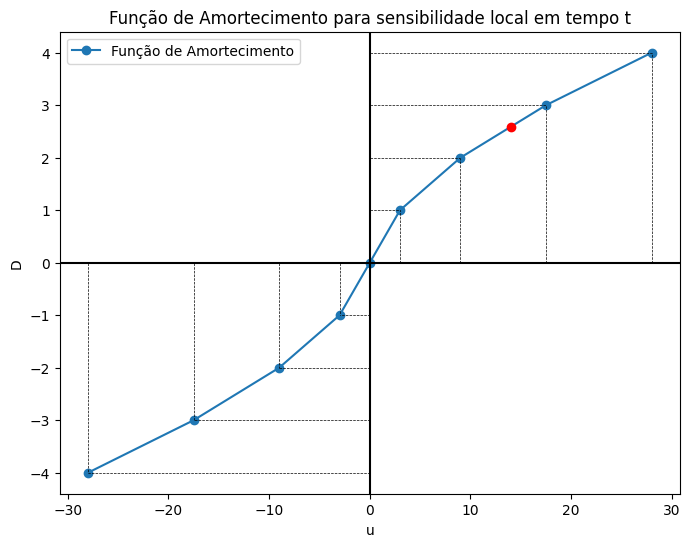

In [27]:
D_obs = Dampening_Function(14, EBC_local_sensitivity_time_t, 0, e)

k = 4
Xs = [0]
Ys = np.array(range(-k, k + 1)).tolist()
for i in range(k):
    x = Xs[i] + EBC_local_sensitivity_time_t(e, i, 0)
    print(x)
    Xs.append(x)

Xs = sorted([-x for x in Xs if x != 0] + Xs)

print(Xs)
print(Ys)

plt.figure(figsize=(8, 6))
plt.plot(Xs, Ys, marker='o', linestyle='-', label="Função de Amortecimento")

for xi, yi in zip(Xs, Ys):
    plt.plot([xi, xi], [0, yi], 'k--', linewidth=0.5)
    plt.plot([0, xi], [yi, yi], 'k--', linewidth=0.5)

plt.plot(14, D_obs, 'ro')

plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')

plt.title('Função de Amortecimento para sensibilidade local em tempo t')
plt.xlabel('u')
plt.ylabel('D')

plt.legend()

plt.show()


5.0
12.5
23.0
37.0
[-37.0, -23.0, -12.5, -5.0, 0, 5.0, 12.5, 23.0, 37.0]
[-4, -3, -2, -1, 0, 1, 2, 3, 4]


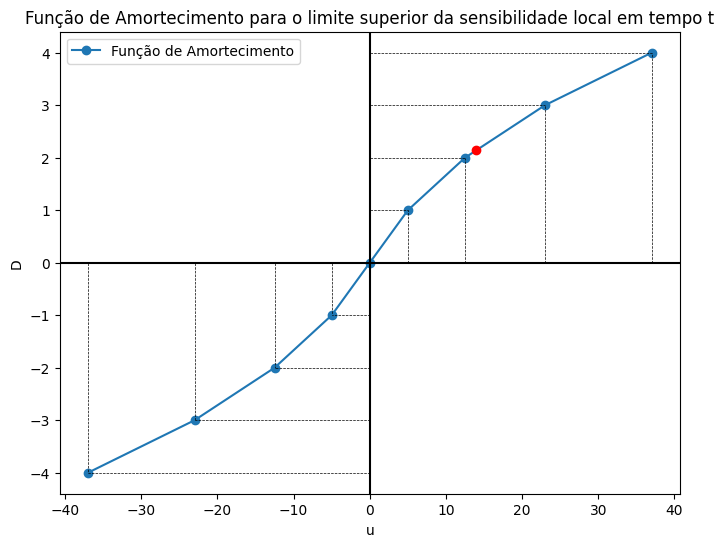

In [28]:
D_obs = Dampening_Function(14, EBC_sensitivity_function, 0, e)

k = 4
Xs = [0]
Ys = np.array(range(-k, k + 1)).tolist()
for i in range(k):
    x = Xs[i] + EBC_sensitivity_function(e, i, 0)
    print(x)
    Xs.append(x)

Xs = sorted([-x for x in Xs if x != 0] + Xs)

print(Xs)
print(Ys)

plt.figure(figsize=(8, 6))
plt.plot(Xs, Ys, marker='o', linestyle='-', label="Função de Amortecimento")

for xi, yi in zip(Xs, Ys):
    plt.plot([xi, xi], [0, yi], 'k--', linewidth=0.5)
    plt.plot([0, xi], [yi, yi], 'k--', linewidth=0.5)

plt.plot(14, D_obs, 'ro')

plt.axhline(y=0, color='black')
plt.axvline(x=0, color='black')

plt.title('Função de Amortecimento para o limite superior da sensibilidade local em tempo t')
plt.xlabel('u')
plt.ylabel('D')

plt.legend()

plt.show()


In [29]:
p = Exponential_Mechanism(u, epsilon = 2, G = e)

p

array([0.27508873, 0.27508873, 0.07497042, 0.07497042, 0.07497042,
       0.07497042, 0.07497042, 0.07497042])

In [30]:
def Dampening_Function_Geral(u, sensibilidade, G, deg = np.array([])):
    D_u = []

    for i in range(len(u)):
        D_u.append(Dampening_Function(u[i], sensibilidade, i, G, deg))
    
    return D_u
    

In [31]:
epsilon = 2

D_u = Dampening_Function_Geral(u, EBC_local_sensitivity_time_t, e, deg = degrees_nodes(e))

p = np.exp(epsilon * np.array(D_u) / 2) 
p /= np.sum(p)

p

array([0.30943103, 0.30943103, 0.06352299, 0.06352299, 0.06352299,
       0.06352299, 0.06352299, 0.06352299])

In [32]:
def Local_Dampening_Mechanism(u, e, epsilon, D_u = []):

    if len(D_u) == 0:
        D_u = Dampening_Function_Geral(u, EBC_sensitivity_function, e)

    p = np.exp(epsilon * np.array(D_u) / 2) 
    p /= np.sum(p)

    return p

In [33]:
Local_Dampening_Mechanism(u, e, 2)

array([0.26266262, 0.26266262, 0.07911246, 0.07911246, 0.07911246,
       0.07911246, 0.07911246, 0.07911246])

In [34]:
def Shifted_Local_Dampening_Mechanism(u, e, epsilon, D_us = []):
    s0 = len(u) * EBC_global_sensitivity(e) + max(u)

    us = u - s0


    if len(D_us) == 0:
        D_us = Dampening_Function_Geral(us, EBC_sensitivity_function, e)

    p = np.exp(epsilon * np.array(D_us) / 2) 
    p /= np.sum(p)

    return p

In [35]:
Shifted_Local_Dampening_Mechanism(u, e, 2)

array([0.42676117, 0.42676117, 0.02441294, 0.02441294, 0.02441294,
       0.02441294, 0.02441294, 0.02441294])

In [37]:
Damp_Enron = np.loadtxt('./data/Enron_DFV.csv', delimiter=',')
Shift_Damp_Enron = np.loadtxt('./data/Enron_SDFV.csv', delimiter=',')
Damp_Github = np.loadtxt('./data/Github_DFV.csv', delimiter=',')
Shift_Damp_Github = np.loadtxt('./data/Github_SDFV.csv', delimiter=',')

In [38]:
K = [5, 10, 20]
epsilons = np.logspace(-3, 4, 100).tolist()

k = 5
epsilon = 2

true_k = np.argsort(degrees_nodes(edges_Enron))[-k:]

true_k

array([1028,  140,  458,  273, 5038], dtype=int64)

In [39]:
nodes = get_nodes(edges_Enron)

accuracys_Shift_Damp_Enron = []

for k in K:

    accuracys = []
    true_k = np.argsort(degrees_nodes(edges_Enron))[-k:]


    for epsilon in epsilons:

        if len(accuracys) == 0 or accuracys[-1:][0] <= 0.9:

            accuracy = 0
            Probs = np.exp((epsilon * np.array(Shift_Damp_Enron)) / 2) 
            Probs /= np.sum(Probs)

            for i in range(100):
                
                top_k = [Choose_r(Probs, k, nodes)]

                accuracy += len(np.intersect1d(top_k, true_k))/k

            accuracy /= 100
        else:
            accuracy = 0.99

        accuracys.append(accuracy)

    accuracys_Shift_Damp_Enron.append(accuracys)

In [40]:
nodes = get_nodes(edges_Enron)

max_Damp_Enron = np.max(Damp_Enron)
normalized_Damp_Enron = (Damp_Enron - max_Damp_Enron)

accuracys_Damp_Enron = []

for k in K:

    accuracys = []
    true_k = np.argsort(degrees_nodes(edges_Enron))[-k:]


    for epsilon in epsilons:

        accuracy = 0
        Probs = np.exp((epsilon * np.array(normalized_Damp_Enron)) / 2) 
        Probs /= np.sum(Probs)

        for i in range(100):
            
            top_k = [Choose_r(Probs, k, nodes)]

            accuracy += len(np.intersect1d(top_k, true_k))/k

        accuracy /= 100



        accuracys.append(accuracy)

    accuracys_Damp_Enron.append(accuracys)

In [41]:
nodes = get_nodes(edges_Enron)

accuracys_Exp_Enron = []

global_sensitivity = EBC_global_sensitivity(edges_Enron)

for k in K:

    accuracys = []
    true_k = np.argsort(degrees_nodes(edges_Enron))[-k:]

    for epsilon in epsilons:

        if len(accuracys) == 0 or accuracys[-1:][0] <= 0.80:
            accuracy = 0

            Probs = np.exp((epsilon * UEnron) / (2 * global_sensitivity)) 
            Probs /= np.sum(Probs)

            for i in range(100):
                
                top_k = [Choose_r(Probs, k, nodes)]

                accuracy += len(np.intersect1d(top_k, true_k))/k

            accuracy /= 100
        else:
            accuracy = 0.99

        accuracys.append(accuracy)

    accuracys_Exp_Enron.append(accuracys)

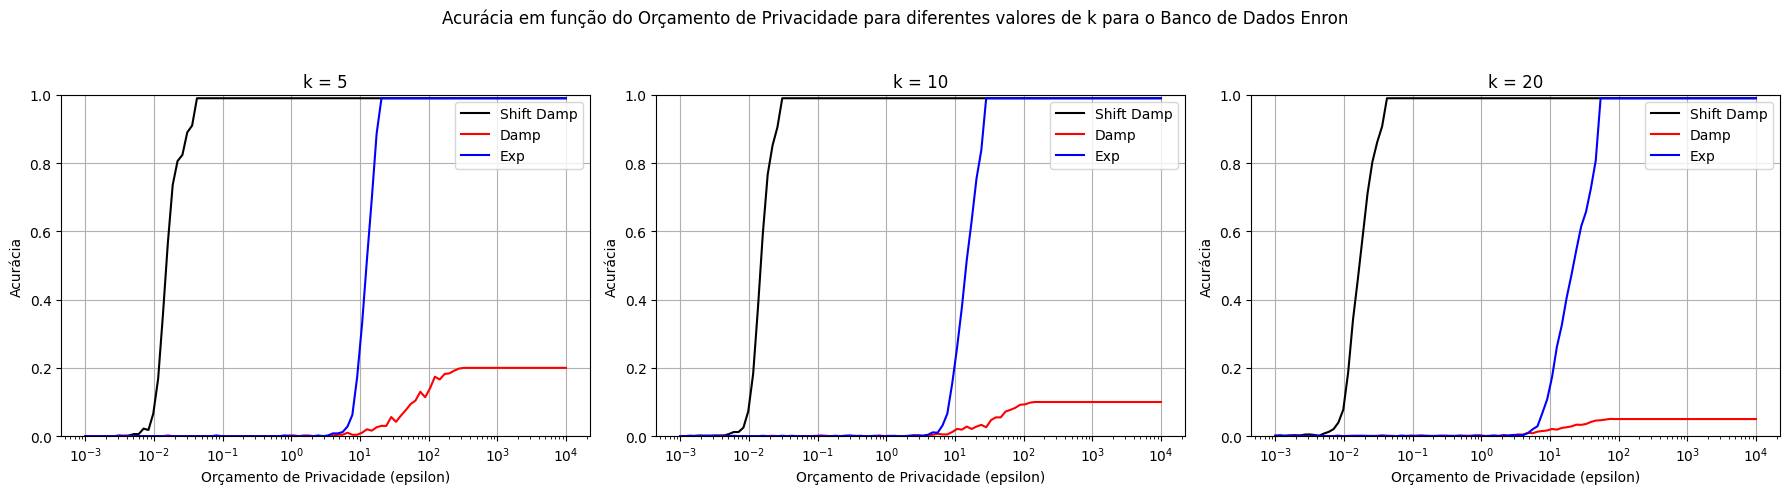

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(K), figsize=(18, 5))

fig.suptitle('Acurácia em função do Orçamento de Privacidade para diferentes valores de k para o Banco de Dados Enron')

for i, k in enumerate(K):
    ax[i].plot(epsilons, accuracys_Shift_Damp_Enron[i], linestyle='-', color='black', label='Shift Damp')
    ax[i].plot(epsilons, accuracys_Damp_Enron[i], linestyle='-', color='red', label='Damp')
    ax[i].plot(epsilons, accuracys_Exp_Enron[i], linestyle='-', color='blue', label='Exp')

    ax[i].set_title(f'k = {k}')
    ax[i].set_xlabel('Orçamento de Privacidade (epsilon)')
    ax[i].set_ylabel('Acurácia')
    ax[i].set_xscale('log')
    ax[i].set_ylim(0, 1)
    ax[i].grid(True)

    specific_epsilon = 10
    if specific_epsilon in epsilons:
        specific_accuracy = accuracys[epsilons.tolist().index(specific_epsilon)]
        ax[i].plot(specific_epsilon, specific_accuracy, 'ro')

    ax[i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [43]:
nodes = get_nodes(edges_Github)

accuracys_Shift_Damp_Github = []

for k in K:

    accuracys = []
    true_k = np.argsort(degrees_nodes(edges_Github))[-k:]


    for epsilon in epsilons:

        if len(accuracys) == 0 or accuracys[-1:][0] <= 0.9:

            accuracy = 0
            Probs = np.exp((epsilon * np.array(Shift_Damp_Github)) / 2) 
            Probs /= np.sum(Probs)

            for i in range(100):
                
                top_k = [Choose_r(Probs, k, nodes)]

                accuracy += len(np.intersect1d(top_k, true_k))/k

            accuracy /= 100
        else:
            accuracy = 0.99

        accuracys.append(accuracy)

    accuracys_Shift_Damp_Github.append(accuracys)

In [44]:
nodes = get_nodes(edges_Github)

max_Damp_Github = np.max(Damp_Github)
normalized_Damp_Github = (Damp_Github - max_Damp_Github)

accuracys_Damp_Github = []

for k in K:

    accuracys = []
    true_k = np.argsort(degrees_nodes(edges_Github))[-k:]


    for epsilon in epsilons:

        accuracy = 0
        Probs = np.exp((epsilon * np.array(normalized_Damp_Github)) / 2) 
        Probs /= np.sum(Probs)

        for i in range(100):
            
            top_k = [Choose_r(Probs, k, nodes)]

            accuracy += len(np.intersect1d(top_k, true_k))/k

        accuracy /= 100



        accuracys.append(accuracy)

    accuracys_Damp_Github.append(accuracys)

In [45]:
nodes = get_nodes(edges_Github)

accuracys_Exp_Github = []

global_sensitivity = EBC_global_sensitivity(edges_Github)

for k in K:

    accuracys = []
    true_k = np.argsort(degrees_nodes(edges_Github))[-k:]

    for epsilon in epsilons:

        if len(accuracys) == 0 or accuracys[-1:][0] <= 0.80:
            accuracy = 0

            Probs = np.exp((epsilon * UGithub) / (2 * global_sensitivity)) 
            Probs /= np.sum(Probs)

            for i in range(100):
                
                top_k = [Choose_r(Probs, k, nodes)]

                accuracy += len(np.intersect1d(top_k, true_k))/k

            accuracy /= 100
        else:
            accuracy = 0.99

        accuracys.append(accuracy)

    accuracys_Exp_Github.append(accuracys)

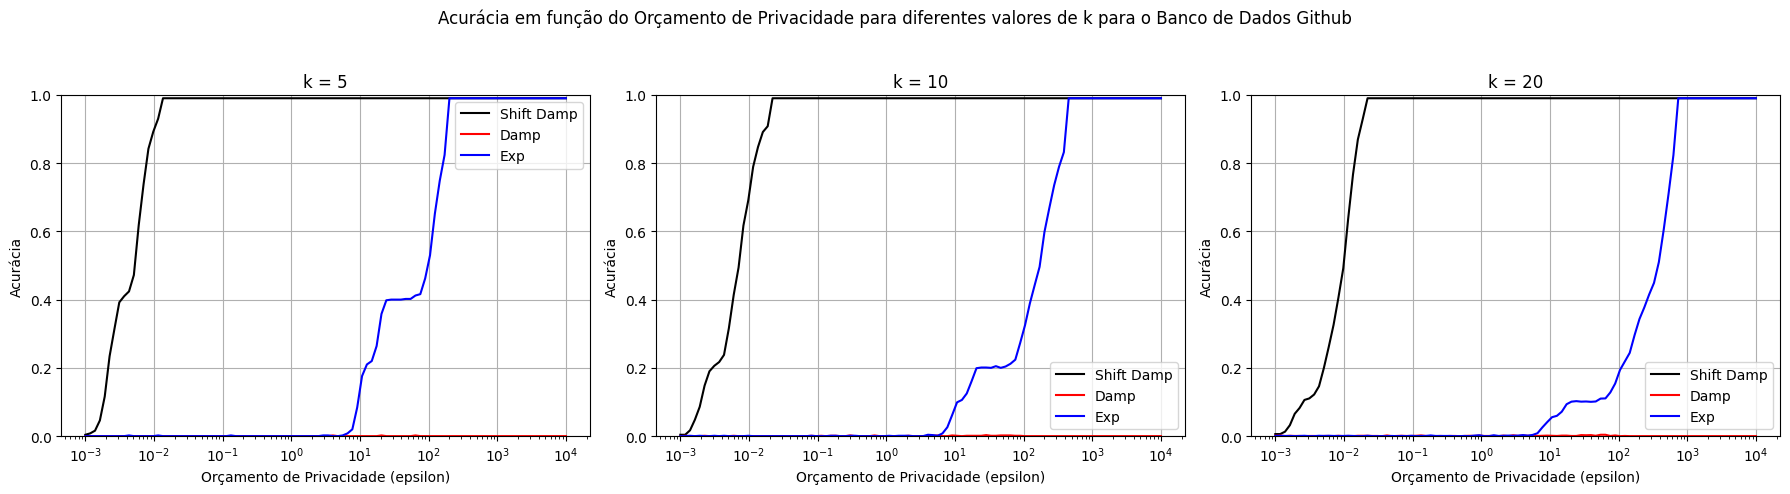

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(K), figsize=(18, 5))

fig.suptitle('Acurácia em função do Orçamento de Privacidade para diferentes valores de k para o Banco de Dados Github')

for i, k in enumerate(K):
    ax[i].plot(epsilons, accuracys_Shift_Damp_Github[i], linestyle='-', color='black', label='Shift Damp')
    ax[i].plot(epsilons, accuracys_Damp_Github[i], linestyle='-', color='red', label='Damp')
    ax[i].plot(epsilons, accuracys_Exp_Github[i], linestyle='-', color='blue', label='Exp')

    ax[i].set_title(f'k = {k}')
    ax[i].set_xlabel('Orçamento de Privacidade (epsilon)')
    ax[i].set_ylabel('Acurácia')
    ax[i].set_xscale('log')
    ax[i].set_ylim(0, 1)
    ax[i].grid(True)

    specific_epsilon = 10
    if specific_epsilon in epsilons:
        specific_accuracy = accuracys[epsilons.tolist().index(specific_epsilon)]
        ax[i].plot(specific_epsilon, specific_accuracy, 'ro')

    ax[i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
